In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import display, display_html

# Konfigurace vizualizace dat
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
matplotlib.style.use('ggplot')
pd.options.display.max_rows = 15

 - Jaky je sum vysledku nahodnych instanci?
 - Od kolika instanci v experimentu ziskavame stejne presne udaje?
 - Je delka vypoctu citliva na maximalni cenu/maximalni vahu?
 - Co ovlivnuje granularita instanci?
 - 
 
 
 - poskytnuty generator je shit, generuje jen nahodu kazdou vterinu, bylo nutne upravit
 

In [3]:
# Gets data
def generatedata(opt, params, cparam, step, max, nogenerate=True):
    if not nogenerate:
            !rm -f out out.tmp out.csv.tmp
    iid = params['iid']
    params['repetition'] = 0
    additive = pd.DataFrame({cparam: {}})
    for cval in np.arange(params[cparam], max, step):
        params[cparam] = cval
        if not nogenerate:
            !./generator/knapgen -I {iid} -n {params['items']} -N {params['instances']} -m {params['capacityratio']} -W {params['maxweight']} -C {params['maxprice']} -k {params['exp']} -d {params['balance']} >> out.tmp 2> /dev/null
        for o in range(iid, iid+params['instances']):
            additive = additive.append(pd.DataFrame({cparam: {o: params[cparam]}}))
        iid += params['instances']
        
    !./target/release/knapsack-problem opt:{opt} out.tmp > out.csv.tmp
    result = pd.read_csv('out.csv.tmp')
    return result.join(additive)

In [10]:
# Displays graphs for data
def investigate(data, cparam):
    fig, axes = plt.subplots(nrows=1, ncols=2)

    timedep = data.groupby(cparam).mean()[['elapsed_ms']]
    axes[0].set_title('Závislost "{}" na "{}"'.format('elapsed_ms', cparam))
    axes[0].plot(timedep, marker = 'o', ls = ':')
    
    qual = data.groupby(cparam).mean()[['price']]
    axes[1].set_title('Závislost "{}" na "{}"'.format('price', cparam))
    axes[1].plot(qual, marker = 'o', ls = ':')

    return {
        'elapsed_min_ms': float(data[['elapsed_ms']].min()),
        'elapsed_max_ms': float(data[['elapsed_ms']].max()),
        'elapsed_amplitude': float(data[['elapsed_ms']].max()-data[['elapsed_ms']].min()),
        'price_min': float(data[['price']].min()),
        'price_max': float(data[['price']].max()),
        'price_amplitude': float(data[['price']].max()-data[['price']].min()),
    }

In [11]:
# Defines unified funciton for a experiment
def experiment(name, config, cparam, step, max):
    display_html('<h1>{}</h1>'.format(name), raw=True)
    display(pd.DataFrame([config]))
    
    data = generatedata(config['opt'], config, cparam, step, max, 'nogenerate' in config)
    data = data.set_index('knap_id')
    
    stats = investigate(data, cparam)
    display(pd.DataFrame([stats]))

Šum výsledků B&B pri 1 instanci / beh

,balance,capacityratio,exp,iid,instances,items,maxprice,maxweight,opt
0,0,0.5,3,0,1,6,200,200,b


,elapsed_amplitude,elapsed_max_ms,elapsed_min_ms,price_amplitude,price_max,price_min
0,0.009952,0.015716,0.005764,350.0,619.0,269.0


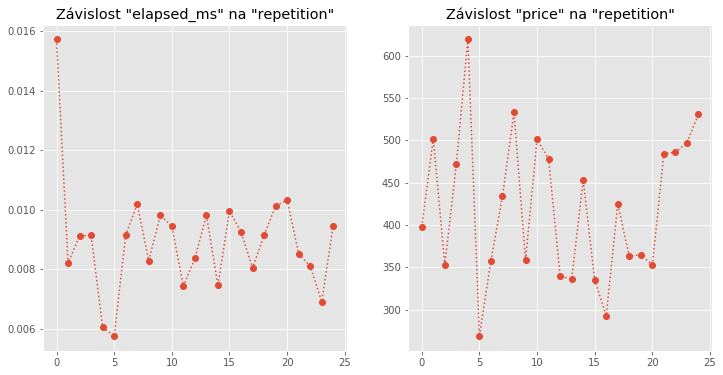

In [17]:
experiment('Šum výsledků B&B pri 1 instanci / beh', { 'opt': 'b', 'iid': 0, 'items': 6, 'instances': 1, 
                               'capacityratio': 0.5, 'maxweight': 200, 'maxprice': 200, 
                               'exp': 3, 'balance': 0 }, 'repetition', 1, 25)

Šum výsledků B&B pri 5 instanci / beh

,balance,capacityratio,exp,iid,instances,items,maxprice,maxweight,opt
0,0,0.5,3,0,5,6,200,200,b


,elapsed_amplitude,elapsed_max_ms,elapsed_min_ms,price_amplitude,price_max,price_min
0,0.015539,0.020817,0.005278,581.0,702.0,121.0


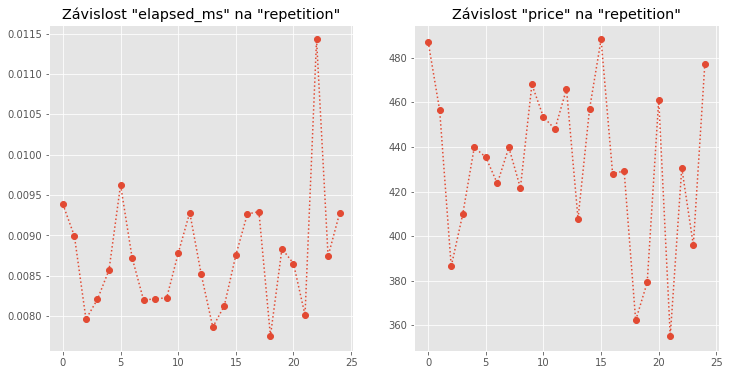

In [18]:
experiment('Šum výsledků B&B pri 5 instanci / beh', { 'opt': 'b', 'iid': 0, 'items': 6, 'instances': 5, 
                               'capacityratio': 0.5, 'maxweight': 200, 'maxprice': 200, 
                               'exp': 3, 'balance': 0 }, 'repetition', 1, 25)

Šum výsledků B&B pri 25 instanci / beh

,balance,capacityratio,exp,iid,instances,items,maxprice,maxweight,opt
0,0,0.5,3,0,25,6,200,200,b


,elapsed_amplitude,elapsed_max_ms,elapsed_min_ms,price_amplitude,price_max,price_min
0,0.011003,0.015246,0.004243,598.0,757.0,159.0


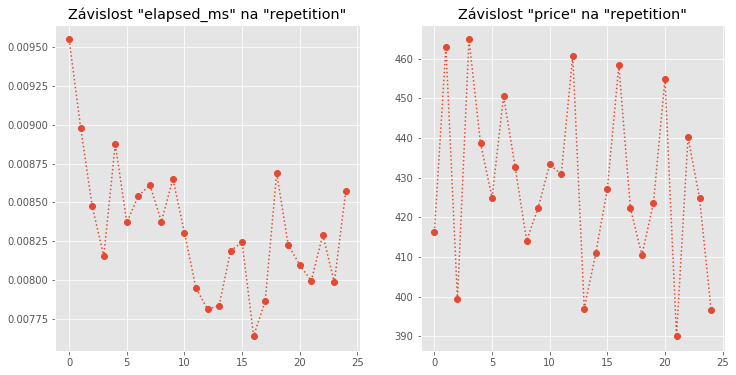

In [19]:
experiment('Šum výsledků B&B pri 25 instanci / beh', { 'opt': 'b', 'iid': 0, 'items': 6, 'instances': 25, 
                               'capacityratio': 0.5, 'maxweight': 200, 'maxprice': 200, 
                               'exp': 3, 'balance': 0 }, 'repetition', 1, 25)

maximalni vaha

,balance,capacityratio,exp,iid,instances,items,maxprice,maxweight,opt
0,0,0.5,4,0,25,6,10,25,r


,elapsed_amplitude,elapsed_max_ms,elapsed_min_ms,price_amplitude,price_max,price_min
0,0.048077,0.05748,0.009403,634.0,650.0,16.0


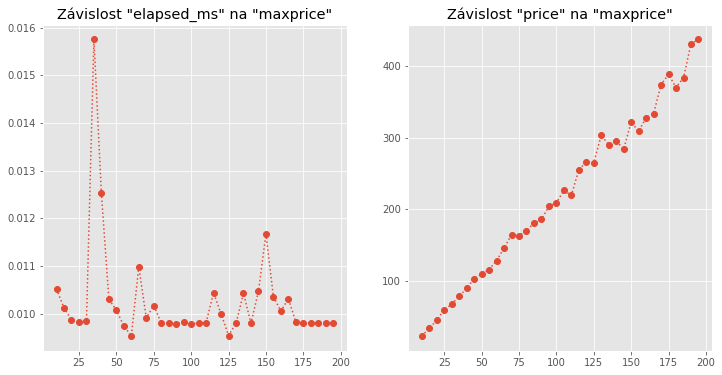

In [23]:
experiment('maximalni vaha', { 'opt': 'r', 'iid': 0, 'items': 6, 'instances': 25, 
                               'capacityratio': 0.5, 'maxweight': 25, 'maxprice': 10, 
                               'exp': 4, 'balance': 0 }, 'maxprice', 5, 200)